In [1]:
package.path = '../?.lua;' .. package.path
require 'torch'
require 'nn'
require 'image'

require 'densecap.DenseCapModel'
utils = require 'densecap.utils'
box_utils = require 'densecap.box_utils'
vis_utils = require 'densecap.vis_utils'

In [2]:
function view_box(box)
    x1 = torch.floor(box[1]-box[3]/2+1)
    y1 = torch.floor(box[2]-box[4]/2+1)
    x2 = x1 + box[3] - 1
    y2 = y1 + box[4] - 1
    itorch.image(img[{ {}, {y1, y2}, {x1, x2} }])
end

In [3]:
-- options
checkpoint = '../data/models/densecap/densecap-pretrained-vgg16.t7'
-- load model
dtype, use_cudnn = utils.setup_gpus(0, 1)
print(dtype, use_cudnn)
model = torch.load(checkpoint).model
model:convert(dtype, use_cudnn)
model:evaluate()

torch.CudaTensor	true	


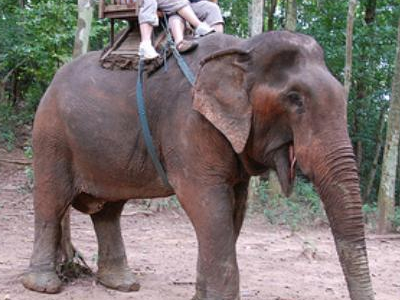

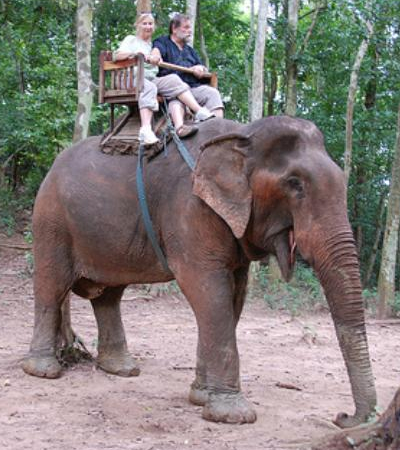

In [37]:
image_size = 720
img_path = '../imgs/elephant.jpg'

-- read image and box
img = image.load(img_path, 3)
box1 = torch.Tensor{400, 260, 400, 300}
box2 = torch.Tensor{400, 250, 400, 450}
-- box2 = torch.Tensor{330, 90, 70, 100}
-- box2 = torch.Tensor{380, 110, 120, 200}
-- box2 = torch.Tensor{380, 90, 40, 100}
view_box(box1)
view_box(box2)
boxes = torch.cat({box1, box2},1):view(2, -1)

In [38]:
-- rescale box and img
boxes = boxes:mul(image_size/math.max(img:size(2), img:size(3)))
img = image.scale(img, image_size):float()
H, W = img:size(2), img:size(3)
-- convert img
img_caffe = img:view(1, 3, H, W)
img_caffe = img_caffe:index(2, torch.LongTensor{3,2,1}):mul(255)
vgg_mean = torch.FloatTensor{103.939, 116.779, 123.68}
vgg_mean = vgg_mean:view(1, 3, 1, 1):expand(1, 3, H, W)
img_caffe:add(-1, vgg_mean)

In [39]:
-- get ONE caption for the target boxes
out = model:forward_boxes(img_caffe:type(dtype), boxes:type(dtype))
obj_scores, seqs, roi_codes, hidden_codes, captions = unpack(out)
print(captions)

{
  1 : elephant is on the ground
  2 : two people riding an elephant
}


In [40]:
-- get BEAM captions for the target boxes
beam_size = 10
output = model:forward_boxes_beams(img_caffe:type(dtype), boxes:type(dtype), beam_size)
beam_captions = output[5]
print(beam_captions)

{
  1 : 
    {
      1 : this is an elephant
      2 : the elephant is brown
      3 : an elephant walking on a dirt road
      4 : the elephant is gray
      5 : an elephant on the ground
      6 : the elephant is on the ground
      7 : an elephant in the middle of the road
      8 : an elephant walking on the ground
      9 : an elephant walking on the road
      10 : an elephant walking on a dirt path
    }
  2 : 
    {
      1 : two people riding an elephant
      2 : people riding an elephant
      3 : three people riding an elephant
      4 : two men riding an elephant
      5 : two people on an elephant
      6 : two people riding a elephant
      7 : two people riding elephants
      8 : two people riding elephant
      9 : two people riding an elephants
      10 : two people riding an elephant in the middle of the road
    }
}
